Sposób zapisu liczby oznaczającej długość jest różny. Dla algorytmów MD4 i MD5 liczbę
zapisujemy w konwencji little-endian, natomiast w algorytmach SHA-1 i SHA-2 w konwencji
big-endian5
.
Pomocna jest tutaj biblioteka struct. Do zapisu liczby w formie 8 bajtów, czyli 64 bitów
w kolejności little-endian można użyć funkcji
struct.pack(”<Q”, n)


In [ ]:
import struct

Załóżmy, że liczymy wartość funkcji skrótu na wiadomości 𝑚 długości 𝑛 < 264
bitów. W pierwszym kroku do wiadomości 𝑚 doczepiamy jeden bit ustawiony na 1, tak aby
był długości 𝑛 + 1. Następnie wstawiamy 𝑣 bitów zerowych, gdzie
𝑣 = 512 − ((𝑛 + 65) mod 512)

In [ ]:
text = b"Ala ma kota"
print(text, len(text), type(text))

n = len(text) *8  ## do bitów
jedynka = b"\x80"
text += jedynka ##W pierwszym kroku do wiadomości 𝑚 doczepiamy jeden bit ustawiony na 1, tak abybył długości 𝑛 + 1

text += b"\x00" * (64- ( len(text)+len(jedynka)*8 )% 64 )
text += struct.pack("<Q", n)
print(len(text) )


b'Ala ma kota' 11 <class 'bytes'>
64


Po uzupełnieniu wiadomości o odpowiednie ciągi bitów wiadomość dzielona jest na
bloki po 512 bitów.


In [ ]:
block_list = [text[i : i + 64] for i in range(0, len(text), 64)]  ## 1 bajt == 8 bitów !!
len(block_list)

1

Dla MD4 stan początkowy to ciąg wartości 𝑠0 = (𝐴, 𝐵, 𝐶, 𝐷), gdzie ustalone stałe to:

𝐴 = 6745230116 = 1732584193,

𝐵 = 𝐸𝐹𝐶𝐷𝐴𝐵8916 = 4023233417,

𝐶 = 98𝐵𝐴𝐷𝐶𝐹𝐸16 = 2562383102,

𝐷 = 1032547616 = 271733878.


In [ ]:
ABCD_list = [1732584193, 4023233417, 2562383102, 271733878] ## [0x67452301, 0xEFCDAB89, 0x98BADCFE, 0x10325476]
ABCD_old = ABCD_list.copy()
print( ABCD_list )

[1732584193, 4023233417, 2562383102, 271733878]


Funkcje kompresji w algorytmach o konstrukcji Merkle’a-Damgårda są wykonywane
w kilku rundach. Do opisu trzech rund wykorzystywanych w MD4 potrzebujemy trzech
pomocniczych funkcji. Każda z nich przyjmuje trzy argumenty będące 32-bitowymi liczbami
całkowitymi nieujemnymi i w wyniku daje jedną 32-bitową liczbę całkowitą nieujemną.

𝐹(𝑥, 𝑦, 𝑧) = (𝑥 ∧ 𝑦) ∨ ((¬𝑥) ∧ 𝑧),

𝐺(𝑥, 𝑦, 𝑧) = (𝑥 ∧ 𝑦) ∨ (𝑦 ∧ 𝑧) ∨ (𝑥 ∧ 𝑧),

𝐻(𝑥, 𝑦, 𝑧) = 𝑥𝛥𝑦𝛥𝑧,

In [ ]:
def F(x, y, z):
    return (x & y) | (~x & z)

def G(x, y, z):
    return (x & y) | (x & z) | (y & z)

def H(x, y, z):
    return x ^ y ^ z


Operacja 𝑎 << 𝑏 oznacza przesunięcie liczby 𝑎 w zapisie binarnym o 𝑏 miejsc w lewo
z obrotem

In [ ]:
def rotate_left(value, shift):  ## https://nickthecrypt.medium.com/cryptography-hash-method-md4-message-digest-4-explained-with-python-f201b74f51d
    return ((value << shift) | (value >> (32 - shift))) & 0xFFFFFFFF

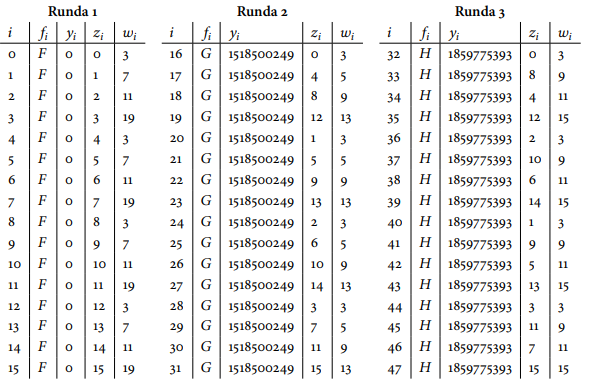

Podczas wyliczania wartości 𝑠𝑖 na podstawie 𝑠𝑖−1, wyciągamy z 𝑠𝑖−1 wartości 𝐴, 𝐵, 𝐶
oraz 𝐷. W każdym z 48 kroków na podstawie stanu opisanego przez zmienne (𝐴, 𝐵, 𝐶, 𝐷)
oraz 512 bitów wiadomości 𝑚𝑖 ułożonej w szesnaście fragmentów po 32 bity, oznaczonych
𝑋0
, … , 𝑋15, wyliczana jest nowa wartość stanu (𝐴′
, 𝐵′
, 𝐶′
, 𝐷′
)jako, kolejno dla 𝑗 = 0, … , 47:

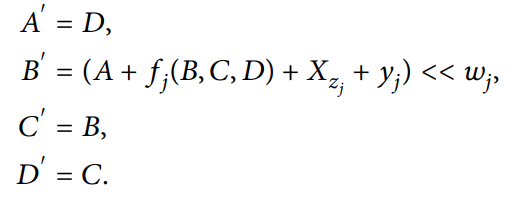

Każda z nich przyjmuje trzy argumenty będące 32-bitowymi liczbami
całkowitymi nieujemnymi i w wyniku daje jedną 32-bitową liczbę całkowitą nieujemną == 16I

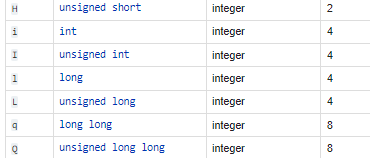

In [ ]:
unpacked_blocks = [ struct.unpack("<16I", block) for block in block_list ]
print( len( unpacked_blocks ), unpacked_blocks )

1 [(543255617, 1797284205, 2153870447, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 88, 0)]


In [ ]:
## Runda 1
z_1_list = list( range(16) )
w_1_list = [3, 7, 11, 19]*4

for unpacked_block in unpacked_blocks: 
    for z, w in zip(z_1_list, w_1_list):
        A_prim = ABCD_list[3]
        new_X = ABCD_list[0] + F( ABCD_list[1], ABCD_list[2], ABCD_list[3] ) + unpacked_block[z] 
        B_prim = rotate_left( new_X & 0xFFFFFFFF, w )
    
        C_prim = ABCD_list[1]
        D_prim = ABCD_list[2]
        ABCD_list = [A_prim, B_prim, C_prim, D_prim]

In [ ]:
## Runda 2
y_2 = 1518500249
z_2_list = [ i for i_start in range(4) for i in range(i_start, 16, 4) ]
w_2_list = [3, 5, 9, 13]*4

for unpacked_block in unpacked_blocks: 
    for z, w in zip(z_2_list, w_2_list):
        A_prim = ABCD_list[3]
        new_X = ABCD_list[0] + G( ABCD_list[1], ABCD_list[2], ABCD_list[3] ) + unpacked_block[z] + y_2
        B_prim = rotate_left( new_X & 0xFFFFFFFF, w )
        C_prim = ABCD_list[1]
        D_prim = ABCD_list[2]
        ABCD_list = [A_prim, B_prim, C_prim, D_prim]

In [ ]:
## Runda 3
y_3 = 1859775393
z_3_list = [0, 8, 4, 12, 2, 10, 6, 14, 1, 9, 5, 13, 3, 11, 7, 15]
w_3_list = [3, 9, 11, 15]*4

for unpacked_block in unpacked_blocks: 
    for z, w in zip(z_3_list, w_3_list):
        A_prim = ABCD_list[3]
        new_X = ABCD_list[0] + H( ABCD_list[1], ABCD_list[2], ABCD_list[3] ) + unpacked_block[z] + y_3
        B_prim = rotate_left( new_X & 0xFFFFFFFF, w )
        C_prim = ABCD_list[1]
        D_prim = ABCD_list[2]
    
        ABCD_list = [A_prim, B_prim, C_prim, D_prim]

Po wykonaniu wszystkich
48 kroków podstawiamy 𝑠𝑖 = 𝑠𝑖−1+ (𝐴, 𝐵, 𝐶, 𝐷), gdzie (𝐴, 𝐵, 𝐶, 𝐷) to 48 razy zaktualizowany
stan 𝑠𝑖−1 według procedury opisanej powyżej.


In [ ]:
ABCD_out = [ (x_list + x_old) & 0xFFFFFFFF for x_list, x_old in zip(ABCD_list, ABCD_old) ]
print(ABCD_out)

[2415591137, 1838320057, 1516839443, 54911818]


In [ ]:
text_encoded = "".join(f"{value:02x}" for value in struct.pack("<4L", *ABCD_out) ) 
print('nasz hasz: ', text_encoded)
print('poprawny: ', 'e1fefa8fb989926d1322695a4ae34503')
print('równość: ', text_encoded=='e1fefa8fb989926d1322695a4ae34503')

nasz hasz:  e1fefa8fb989926d1322695a4ae34503
poprawny:  e1fefa8fb989926d1322695a4ae34503
równość:  True
